# Homework 03: Learning Curves and Training Workflow

## Due: Midnight on September 21 (with 2-hour grace period)

**Points:** 85

In this assignment, you will learn how to design, train, and evaluate neural networks by systematically exploring key design choices. Your focus will be on developing an effective **training workflow** — using learning curves and validation metrics to guide your decisions.

We'll use the **Forest Cover Type (Covertype) dataset,** which has ~581k tabular records with 54 cartographic/topographic features (elevation, aspect, slope, soil and wilderness indicators) used to predict one of seven tree cover types in Colorado’s Roosevelt National Forest. It’s a large, mildly imbalanced multi-class benchmark commonly used to compare classical ML and deep learning on tabular data.

We will start with a **baseline model** (two hidden layers of sizes 64 and 32), and gradually introduce and tune different hyperparameters. Each of the first five problems considers  different hyperparameter choices, and the last problem is your chance to use what you have learned to design your best model:

1. **Activation function** – Compare ReLU, sigmoid, and tanh to see which provides the best accuracy.
2. **Learning rate** – Explore a range of learning rates and identify which balances convergence speed and stability.
3. **Dropout** – Investigate how different dropout rates reduce overfitting and where they are most effective.
4. **L2 regularization** – Experiment with weight penalties to encourage simpler models and avoid memorization.
5. **Dropout + L2** – Combine both regularization techniques and study their interaction.
6. **Best model design** – Use all your insights to build and train your strongest model, with the option to try **learning rate scheduling** for further improvement.

Throughout, you will use **early stopping** to select the model at the epoch of **minimum validation loss**, and you will report the **validation accuracy** of that selected model as the primary measure of performance.

By the end of this homework, you will not only understand how different hyperparameters affect training and generalization, but also gain hands-on practice in building a disciplined workflow for model development.

There are 10 graded problems, worth 8 points each, with 5 points for free if you complete the homework. 

In [1]:
# Useful imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import time
import os

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input,Dropout
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay


from tensorflow.keras.datasets import fashion_mnist

# utility code

random_seed = 42

def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages


2025-09-19 07:45:37.930674: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Utility function to plot learning curves and keep track of all results

# Call `print_results()` to see listing of all results logged so far


def plot_learning_curves(hist, title, verbose=True):
    
    val_losses = hist.history['val_loss']
    min_val_loss = min(val_losses)
    min_val_epoch = val_losses.index(min_val_loss)
    val_acc_at_min_loss = hist.history['val_accuracy'][min_val_epoch]

    epochs = range(1, len(val_losses) + 1)  # epoch numbers starting at 1

    fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

    # --- Loss Plot ---
    axs[0].plot(epochs, hist.history['loss'], label='train loss')
    axs[0].plot(epochs, hist.history['val_loss'], label='val loss')
    axs[0].scatter(min_val_epoch + 1, min_val_loss, color='red', marker='x', s=50, label='min val loss')
    axs[0].set_title(f'{title} - Categorical Cross-Entropy Loss')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # --- Accuracy Plot ---
    axs[1].plot(epochs, hist.history['accuracy'], label='train acc')
    axs[1].plot(epochs, hist.history['val_accuracy'], label='val acc')
    axs[1].scatter(min_val_epoch + 1, val_acc_at_min_loss, color='red', marker='x', s=50, label='acc @ min val loss')
    axs[1].set_title(f'{title} - Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].grid(True)
    axs[1].set_ylim(0, 1.05)

    plt.tight_layout()
    plt.show()

    if verbose:
        print(f"Final Training Loss:            {hist.history['loss'][-1]:.4f}")
        print(f"Final Training Accuracy:        {hist.history['accuracy'][-1]:.4f}")
        print(f"Final Validation Loss:          {hist.history['val_loss'][-1]:.4f}")
        print(f"Final Validation Accuracy:      {hist.history['val_accuracy'][-1]:.4f}")
        print(f"Minimum Validation Loss:        {min_val_loss:.4f} (Epoch {min_val_epoch + 1})")
        print(f"Validation Accuracy @ Min Loss: {val_acc_at_min_loss:.4f}")

    results[title] = (val_acc_at_min_loss,{min_val_epoch + 1})

results = {}

**The plotting function will record the validation accuracy for each experiment, using the plot title as key. The next function will print these out (see the last cell in the notebook).**


In order to see all results, you must give a different plot title to each experiment.

In [3]:
def print_results():
    for title, (acc, ep) in sorted(results.items(), 
                                   key=lambda kv: kv[1][0],   # kv[1] is (acc, epoch); [0] is acc
                                   reverse=True
                                  ):
        print(f"{title:<40}\t{acc:.4f}")

### Wrapper to train, display results, and run test set

We assume multi-class classification, and allow setting various parameters for training. 

In [4]:
# Uses globals X_train,y_train,X_val,y_val

def train_and_test(model, 
                   epochs        = 500,                   # Just needs to be bigger than early stop point
                   lr_schedule   = 0.001,                 # Adam default / 10 seems to work well for this dataset
                   optimizer     = "Adam",
                   title         = "Learning Curves",
                   batch_size    = 64,                     # experiments confirmed this was optimal with other parameters at default
                   use_early_stopping = True,
                   patience      = 10,                                       
                   min_delta     = 0.0001,                 
                   callbacks     = [],                     # for extra callbacks other than early stopping
                   verbose       = 0,
                   return_history = False
                  ):

    print(f"\n{title}\n")


    if optimizer == "Adam":
        opt = Adam(learning_rate=lr_schedule) 
    else:
        opt = optimizer
    
    #Compiling the model
    model.compile(optimizer=opt, 
                  loss="sparse_categorical_crossentropy", 
                  metrics=["accuracy"]
                 )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        min_delta=min_delta,
        restore_best_weights=True,               # this will mean that the model which produced the smallest validation loss will be returned
        verbose=verbose
    )
    

    if use_early_stopping:
        cbs=[early_stop] + callbacks
    else:
        cbs=callbacks

    # start timer
    start = time.time()
    
    # Fit the model with early stopping
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),       # must use stratified validation set
                        callbacks=cbs,
                        verbose=verbose
                       )

    if use_early_stopping:
        best_epoch = early_stop.best_epoch
        best_acc   = history.history['val_accuracy'][best_epoch]
    else:
        best_epoch = np.argmax(history.history['val_accuracy'])
        best_acc   = history.history['val_accuracy'][best_epoch]
    
    # Plot training history
    plot_learning_curves(history, title=title)

    # Evaluate on test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    print(f"\nValidation-Test Gap (accuracy): {abs(best_acc - test_accuracy):.6f}")
    
    # Record end time and print execution time
    end = time.time()
    print(f"\nExecution Time: " + format_hms(end-start))

    if return_history:
        return history

### Load the dataset and extract a stratified subset

This datasest is rather large (581,012 samples) and unbalanced, but for the purposes of this homework, we use a much smaller set, and select samples so that it is balanced. 

In [5]:
# complete cell: load, balance, split into X_train/y_train/x_val/y_val/X_test/y_test, and standardize
from collections import Counter
from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# 1) load
x, y = fetch_covtype(return_X_y=True)  # y in {1..7}
print("full dataset shape:", x.shape)

# 2) build a perfectly balanced subset across 7 classes (no replacement)
classes, counts = np.unique(y, return_counts=True)
# min_count = counts.min()  # size of rarest class                         # You can modify this parameter to increase the size of the dataset, but above
min_count = 1000                                                           # counts.min() you'll produce an unbalanced set. 


rng = np.random.default_rng(42)

idx_list = []
for c in classes:
    c_idx = np.where(y == c)[0]
    chosen = rng.choice(c_idx, size=min_count, replace=False)
    idx_list.append(chosen)

idx_bal = np.concatenate(idx_list)
rng.shuffle(idx_bal)

X_sub = x[idx_bal]
y_sub = y[idx_bal] - 1  # relabel to {0..6} for keras
print("balanced subset shape:", X_sub.shape, "class counts:", dict(Counter(y_sub)))

# 3) stratified 60/20/20 split (train/val/test)
test_size = 0.20
val_size = 0.20  # of the whole dataset

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_sub, y_sub, test_size=test_size, random_state=random_seed, stratify=y_sub
)
val_size_rel = val_size / (1.0 - test_size)  # e.g., 0.20 / 0.80 = 0.25

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=val_size_rel, random_state=random_seed, stratify=y_trainval
)

# 4) standardize using train-only stats (float32 for tensorflow friendliness)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_val   = scaler.transform(X_val).astype(np.float32)
X_test  = scaler.transform(X_test).astype(np.float32)

# 5) quick sanity checks
def show_counts(name, y_arr):
    c = Counter(y_arr)
    total = sum(c.values())
    print(f"{name}: total={total}, per-class={dict(c)}")

print("shapes:", "X_train", X_train.shape, "X_val", X_val.shape, "X_test", X_test.shape)
show_counts("train", y_train)
show_counts("val  ", y_val)
show_counts("test ", y_test)

# you now have: X_train, y_train, X_val, y_val, X_test, y_test

# Looks like integer encoded multi-class, let's check and define the global n_classes

labels = np.unique(y_train)

n_classes = len(labels)

print("class labels:",labels)


full dataset shape: (581012, 54)
balanced subset shape: (7000, 54) class counts: {2: 1000, 0: 1000, 4: 1000, 5: 1000, 1: 1000, 3: 1000, 6: 1000}
shapes: X_train (4200, 54) X_val (1400, 54) X_test (1400, 54)
train: total=4200, per-class={2: 600, 1: 600, 0: 600, 3: 600, 5: 600, 4: 600, 6: 600}
val  : total=1400, per-class={1: 200, 6: 200, 5: 200, 4: 200, 3: 200, 2: 200, 0: 200}
test : total=1400, per-class={0: 200, 6: 200, 2: 200, 3: 200, 4: 200, 5: 200, 1: 200}
class labels: [0 1 2 3 4 5 6]


## Prelude: Defining a model builder

In order to facilitate our experimentation, we'll write a function which builds models according to specifications:

- How many layers
- How wide each layer is
- How much dropout in each layer
- How much L2 Regularization in each layer

This is a fairly standard practice in ML, since the structure of simple models is fairly predictable and can be specified by a few hyperparameters. 

In [6]:
# This function will build a multi-class classifier with dropout and L2 regularization.
# You must specify the number of input features, the number of classes, and a list of layer hyperparameters
# in the form  [ ...., (width, activation function, L2 lambda, dropout rate), .... ]

# Note that when adding dropout, this appears as a separate layer, but it has no parameters to be trained. 

def build_model(n_inputs,layer_list,n_classes):
    layers = [ Input(shape=(n_inputs,)) ]
    for (width,act,l2_lambda,dropout_rate) in layer_list:
        layers.append( Dense(width, activation=act, kernel_regularizer=regularizers.l2(l2_lambda)) )
        if dropout_rate > 0:
            layers.append( Dropout(dropout_rate) )
    layers.append( Dense(n_classes, activation='softmax') )
    return models.Sequential( layers )


**Example: To build the following model:**

In [7]:
model = models.Sequential(
   [
    Input(shape=(X_train.shape[1],)),                              
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0)),              # 0.0 means no regularization applied; no dropout, so no Dropout layer necessary
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.3),
    Dense(n_classes, activation='softmax')
   ]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,831 (22.78 KB)

 Trainable params: 5,831 (22.78 KB)

 Non-trainable params: 0 (0.00 B)

**We call `build_model` as shown here:**

In [8]:
build_model(X_train.shape[1], [ (64,'relu',0.0,0.0), (32,'relu',0.001,0.3)], n_classes).summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,831 (22.78 KB)

 Trainable params: 5,831 (22.78 KB)

 Non-trainable params: 0 (0.00 B)

-------------------



### Baseline Model Architecture

**Problems 1–5 will use the following baseline model structure,** implemented with the provided `build_model` function and trained using `train_and_test`:

```
input → 64 → 32 → output
```

* Two hidden layers of widths 64 and 32.
* Activation function, dropout rate, and L2 regularization term (λ) will vary as specified in each problem.
* **Early stopping** is always applied to select the model at the epoch of **minimum validation loss**.
* We will report the **validation accuracy** of the selected model as the primary metric.


### Problem One: Which Activation Function?

In this problem, you will train the **baseline neural network** and investigate which activation function produces the best performance. The model you create will be the one saved by **early stopping** — that is, the epoch where validation loss is minimized.

**Steps to follow:**

* Use the provided functions `train_and_test` and `build_model` to create a model named **`model_baseline`**.
* Train and evaluate this model using each of the following activation functions in the hidden layers:

  * `relu`
  * `sigmoid`
  * `tanh`
* Identify which activation function produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.



Baseline - ReLU



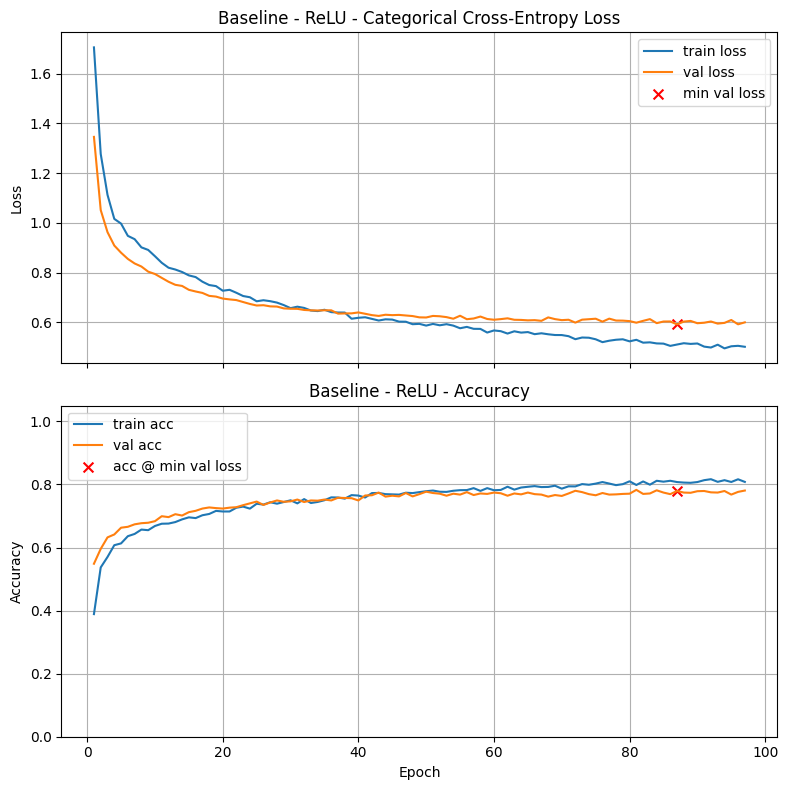

Final Training Loss:            0.5017
Final Training Accuracy:        0.8081
Final Validation Loss:          0.6000
Final Validation Accuracy:      0.7807
Minimum Validation Loss:        0.5917 (Epoch 87)
Validation Accuracy @ Min Loss: 0.7793

Test Loss: 0.6020
Test Accuracy: 0.7779

Validation-Test Gap (accuracy): 0.001429

Execution Time: 00:00:44


In [9]:
# Your code here. Add as many cells as you need. 
model_baseline = build_model(
    n_inputs=X_train.shape[1],
    layer_list=[ 
        (64, 'relu',    0.0,  0.0), 
        (32, 'relu',    0.001, 0.3)
    ],
    n_classes=n_classes
)

train_and_test(model_baseline, title="Baseline - ReLU")



Baseline - Sigmoid



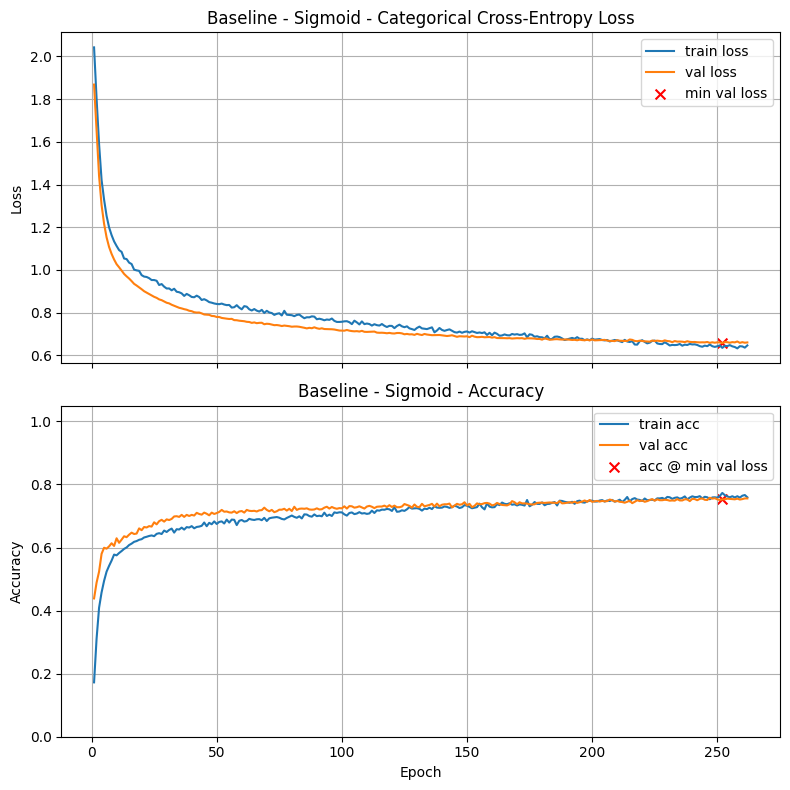

Final Training Loss:            0.6468
Final Training Accuracy:        0.7593
Final Validation Loss:          0.6607
Final Validation Accuracy:      0.7557
Minimum Validation Loss:        0.6578 (Epoch 252)
Validation Accuracy @ Min Loss: 0.7529

Test Loss: 0.6693
Test Accuracy: 0.7514

Validation-Test Gap (accuracy): 0.001429

Execution Time: 00:01:51


In [10]:
model_baseline = build_model(
    n_inputs=X_train.shape[1],
    layer_list=[ 
        (64, 'sigmoid', 0.0,  0.0), 
        (32, 'sigmoid', 0.001, 0.3)
    ],
    n_classes=n_classes
)

train_and_test(model_baseline, title="Baseline - Sigmoid")



Baseline - Tanh



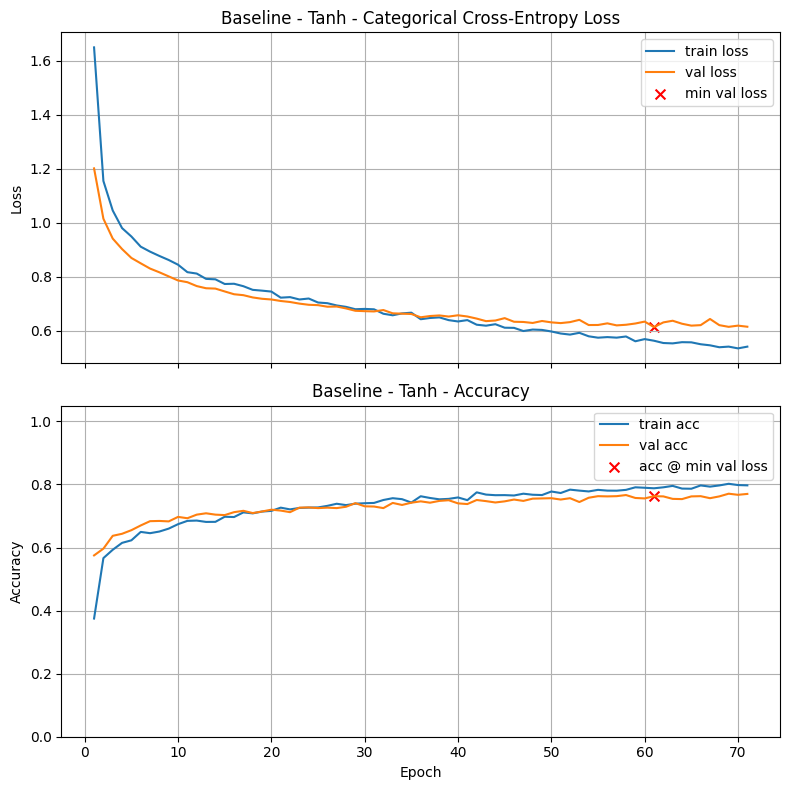

Final Training Loss:            0.5415
Final Training Accuracy:        0.7971
Final Validation Loss:          0.6152
Final Validation Accuracy:      0.7700
Minimum Validation Loss:        0.6138 (Epoch 61)
Validation Accuracy @ Min Loss: 0.7629

Test Loss: 0.6322
Test Accuracy: 0.7586

Validation-Test Gap (accuracy): 0.004286

Execution Time: 00:00:29


In [11]:
model_baseline = build_model(
    n_inputs=X_train.shape[1],
    layer_list=[ 
        (64, 'tanh',    0.0,  0.0), 
        (32, 'tanh',    0.001, 0.3)
    ],
    n_classes=n_classes
)

train_and_test(model_baseline, title="Baseline - Tanh")


In [12]:
print_results()


Baseline - ReLU                         	0.7793
Baseline - Tanh                         	0.7629
Baseline - Sigmoid                      	0.7529


### Graded Questions

In [13]:
# Set a1a to the activation function which provided the best validation accuracy at the epoch of minimum validation loss

a1a = 0             # Replace with integer 0 (relu), 1 (sigmoid), or 2 (tanh)

In [14]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a1a = {a1a}') 


a1a = 0


In [15]:
# Set a1b to the validation accuracy found by this best activation function

a1b = 0.7793             # Replace 0.0 with your answer

In [16]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a1b = {a1b:.4f}') 

a1b = 0.7793


### Problem Two: Finding the Right Learning Rate

In this problem, you will continue working with the **baseline model** and determine which learning rate produces the best performance. As before, the model you evaluate should be the one saved by **early stopping** — the epoch where validation loss is minimized.

**Steps to follow:**

* Build and train the **baseline model** using the **activation function identified in Problem One**.

* Train and evaluate this model using each of the following learning rates:

  ```
      [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]
  ```

* Identify which learning rate produces the **best validation accuracy** at the epoch of **minimum validation loss**, within a maximum of **500 epochs**.

* Answer the graded questions.


**Note: Smaller learning rates will generally take more epochs to reach the optimal point, so some of these will not engage early stopping, but run the full 500 epochs.**



LR = 1e-03



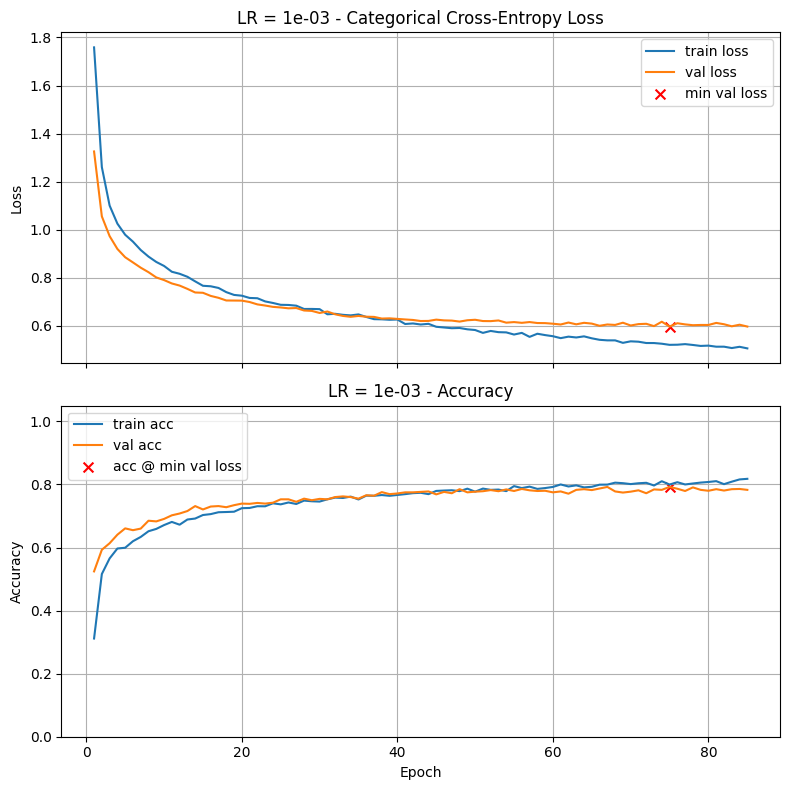

Final Training Loss:            0.5069
Final Training Accuracy:        0.8179
Final Validation Loss:          0.5977
Final Validation Accuracy:      0.7829
Minimum Validation Loss:        0.5977 (Epoch 75)
Validation Accuracy @ Min Loss: 0.7921

Test Loss: 0.6113
Test Accuracy: 0.7743

Validation-Test Gap (accuracy): 0.017857

Execution Time: 00:00:33

LR = 5e-04



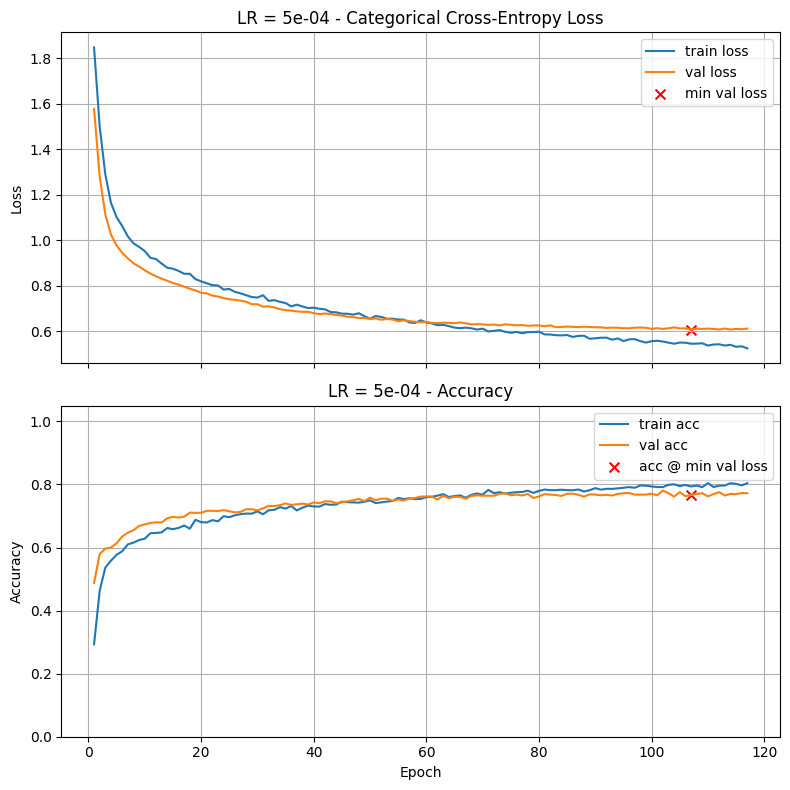

Final Training Loss:            0.5242
Final Training Accuracy:        0.8040
Final Validation Loss:          0.6111
Final Validation Accuracy:      0.7721
Minimum Validation Loss:        0.6066 (Epoch 107)
Validation Accuracy @ Min Loss: 0.7664

Test Loss: 0.6261
Test Accuracy: 0.7571

Validation-Test Gap (accuracy): 0.009286

Execution Time: 00:00:40

LR = 1e-04



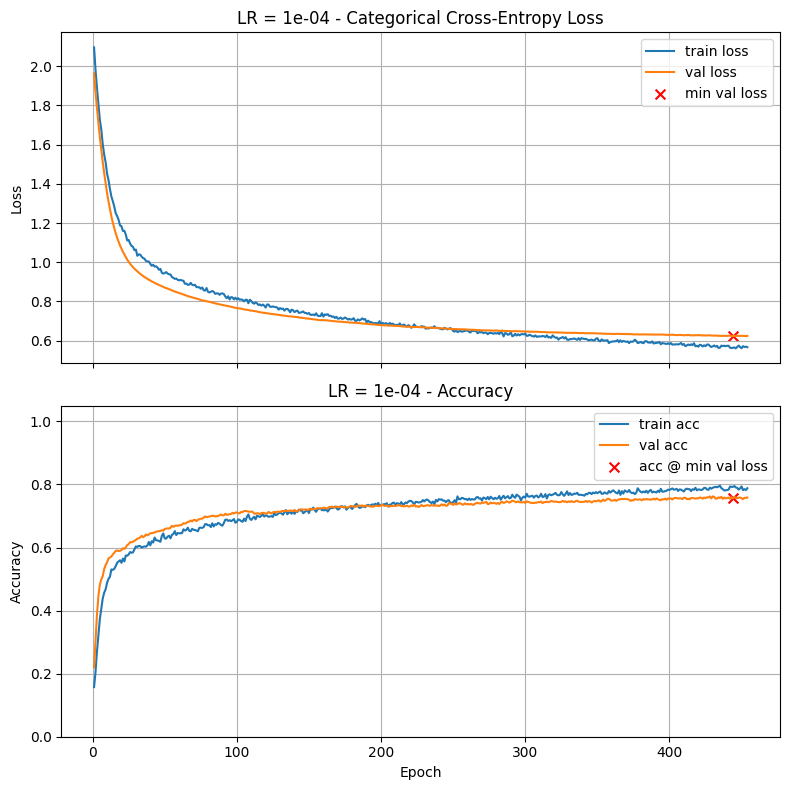

Final Training Loss:            0.5661
Final Training Accuracy:        0.7881
Final Validation Loss:          0.6238
Final Validation Accuracy:      0.7586
Minimum Validation Loss:        0.6224 (Epoch 444)
Validation Accuracy @ Min Loss: 0.7557

Test Loss: 0.6263
Test Accuracy: 0.7629

Validation-Test Gap (accuracy): 0.007143

Execution Time: 00:02:28

LR = 5e-05



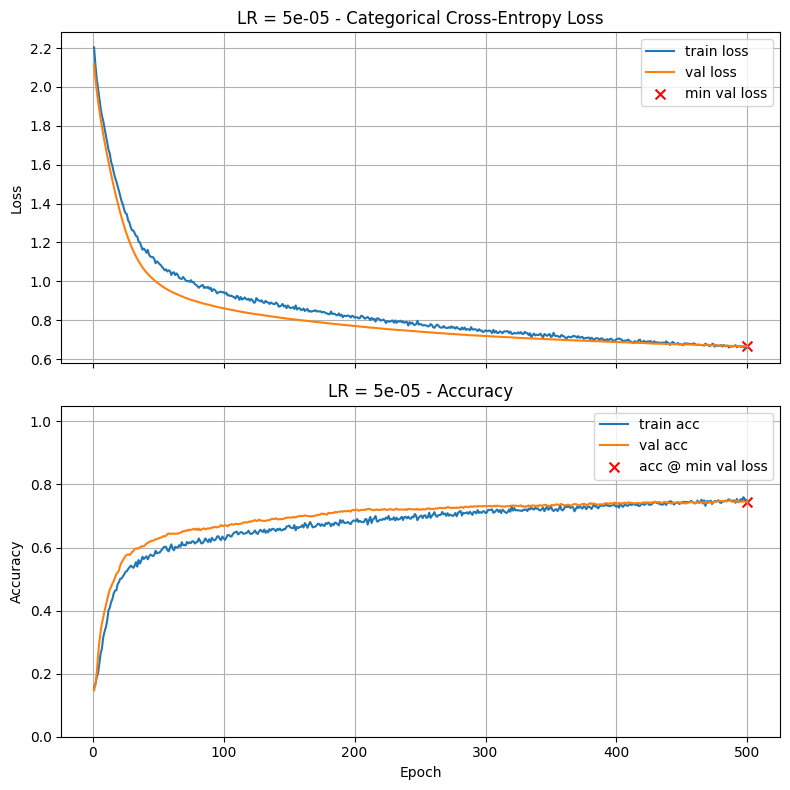

Final Training Loss:            0.6658
Final Training Accuracy:        0.7445
Final Validation Loss:          0.6648
Final Validation Accuracy:      0.7457
Minimum Validation Loss:        0.6648 (Epoch 500)
Validation Accuracy @ Min Loss: 0.7457

Test Loss: 0.6888
Test Accuracy: 0.7257

Validation-Test Gap (accuracy): 0.020000

Execution Time: 00:02:56

LR = 1e-05



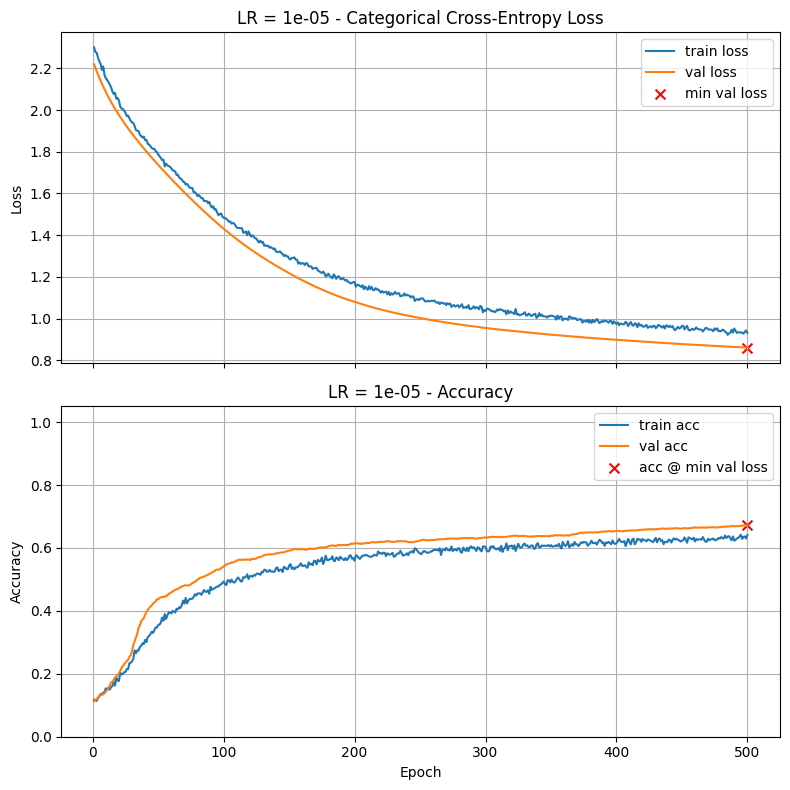

Final Training Loss:            0.9313
Final Training Accuracy:        0.6410
Final Validation Loss:          0.8605
Final Validation Accuracy:      0.6721
Minimum Validation Loss:        0.8605 (Epoch 500)
Validation Accuracy @ Min Loss: 0.6721

Test Loss: 0.8715
Test Accuracy: 0.6664

Validation-Test Gap (accuracy): 0.005714

Execution Time: 00:04:16


In [17]:
# Your code here. Add as many cells as you need. 
learning_rates = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]

for lr in learning_rates:
    model_baseline = build_model(
        n_inputs=X_train.shape[1],
        layer_list=[
            (64, 'relu', 0.0, 0.0),          
            (32, 'relu', 0.001, 0.3)         
        ],
        n_classes=n_classes
    )

    title = f"LR = {lr:.0e}"
    train_and_test(
        model_baseline,
        title=title,
        lr_schedule=lr,
        epochs=500,
        verbose=0
    )


In [18]:
print_results()


LR = 1e-03                              	0.7921
Baseline - ReLU                         	0.7793
LR = 5e-04                              	0.7664
Baseline - Tanh                         	0.7629
LR = 1e-04                              	0.7557
Baseline - Sigmoid                      	0.7529
LR = 5e-05                              	0.7457
LR = 1e-05                              	0.6721


#### Graded Questions

In [19]:
# Set a2a to the learning rate which provided the best validation accuracy at the epoch of minimum validation loss

a2a = 1e-03          # Replace 0.0 with your answer

In [20]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2a = {a2a:.6f}') 

a2a = 0.001000


In [21]:
# Set a2b to the validation accuracy found by this best learning rate

a2b = 0.7921             # Replace 0.0 with your answer

In [22]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2b = {a2b:.4f}') 

a2b = 0.7921


### Problem Three: Dropout

In this problem, you will explore how **dropout** can help prevent overfitting in neural networks. There are no absolute rules, but some useful hueristics are:

* Dropout typically works best in **later dense layers** (e.g., the second hidden layer of width 32) in the range **0.3–0.5**.
* If applied to **earlier layers** (e.g., the first hidden layer), dropout should be smaller, typically **0.0–0.2** (where 0.0 means no dropout).

**Steps to follow:**

* Build and train the **baseline model** using the **activation function from Problem One** and the **learning rate from Problem Two**.
* Investigate dropout in the ranges suggested, using increments of **0.1**.
* Identify which dropout configuration produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.



Dropout d1=0.0, d2=0.3



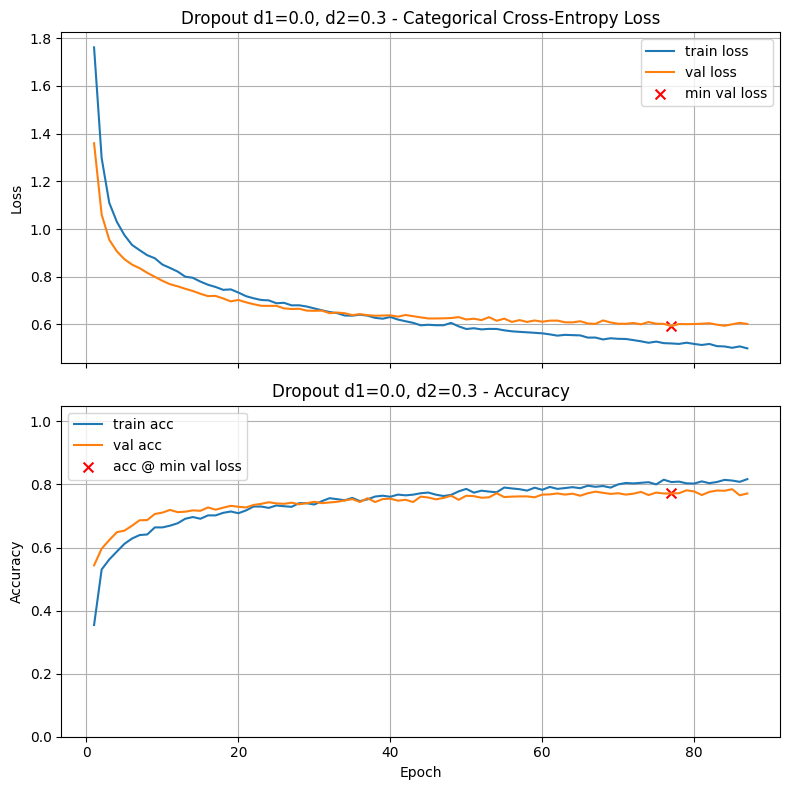

Final Training Loss:            0.4998
Final Training Accuracy:        0.8169
Final Validation Loss:          0.6022
Final Validation Accuracy:      0.7714
Minimum Validation Loss:        0.5939 (Epoch 77)
Validation Accuracy @ Min Loss: 0.7714

Test Loss: 0.6024
Test Accuracy: 0.7743

Validation-Test Gap (accuracy): 0.002857

Execution Time: 00:00:40

Dropout d1=0.0, d2=0.4



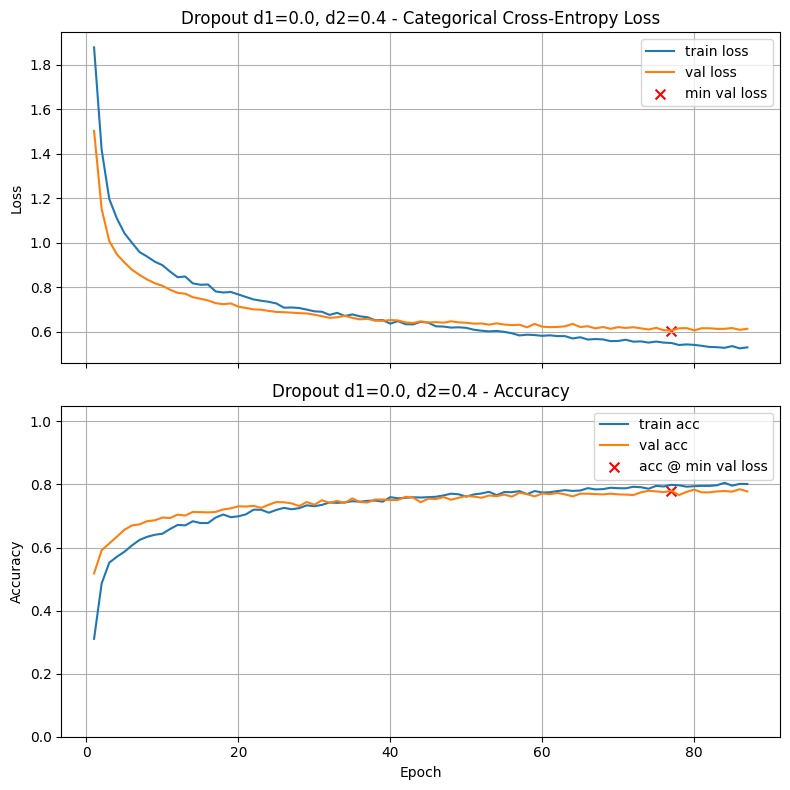

Final Training Loss:            0.5290
Final Training Accuracy:        0.8014
Final Validation Loss:          0.6127
Final Validation Accuracy:      0.7779
Minimum Validation Loss:        0.6046 (Epoch 77)
Validation Accuracy @ Min Loss: 0.7800

Test Loss: 0.6226
Test Accuracy: 0.7671

Validation-Test Gap (accuracy): 0.012857

Execution Time: 00:00:46

Dropout d1=0.0, d2=0.5



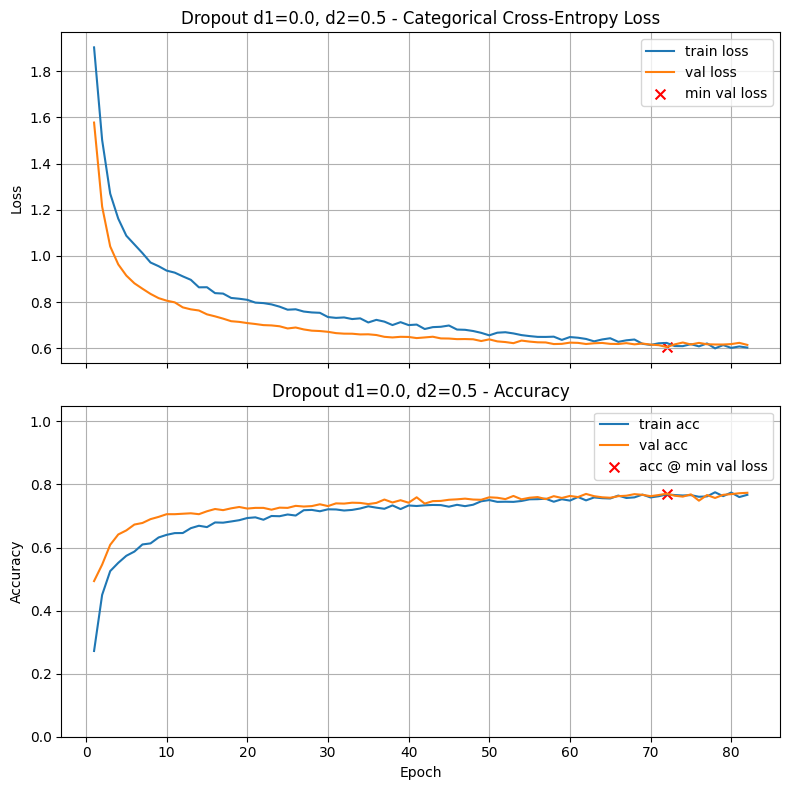

Final Training Loss:            0.6028
Final Training Accuracy:        0.7671
Final Validation Loss:          0.6144
Final Validation Accuracy:      0.7736
Minimum Validation Loss:        0.6054 (Epoch 72)
Validation Accuracy @ Min Loss: 0.7707

Test Loss: 0.6403
Test Accuracy: 0.7521

Validation-Test Gap (accuracy): 0.018571

Execution Time: 00:00:45

Dropout d1=0.1, d2=0.3



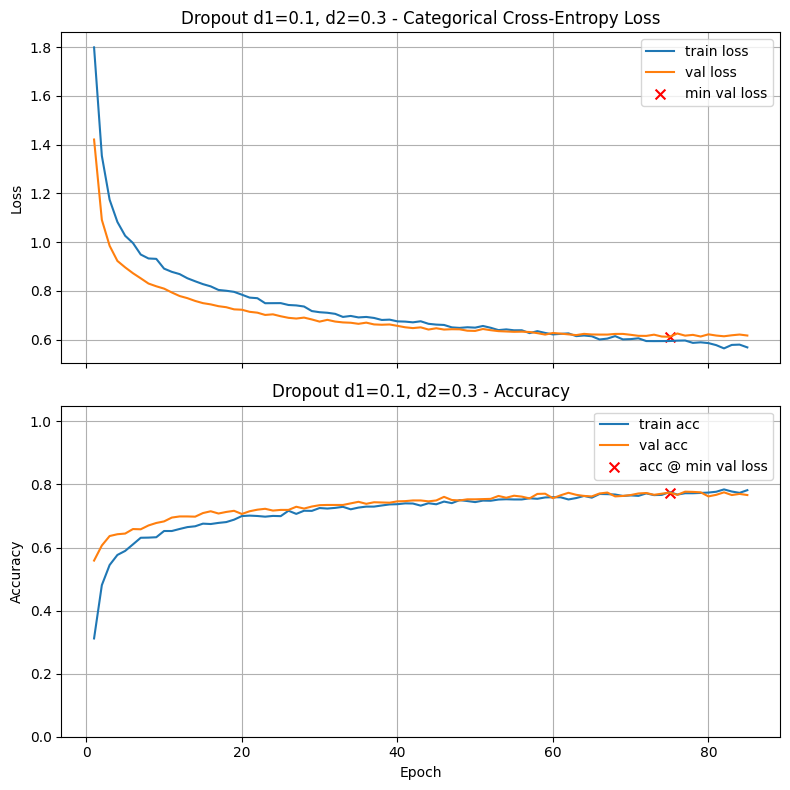

Final Training Loss:            0.5681
Final Training Accuracy:        0.7819
Final Validation Loss:          0.6167
Final Validation Accuracy:      0.7664
Minimum Validation Loss:        0.6115 (Epoch 75)
Validation Accuracy @ Min Loss: 0.7743

Test Loss: 0.6260
Test Accuracy: 0.7621

Validation-Test Gap (accuracy): 0.012143

Execution Time: 00:00:50

Dropout d1=0.1, d2=0.4



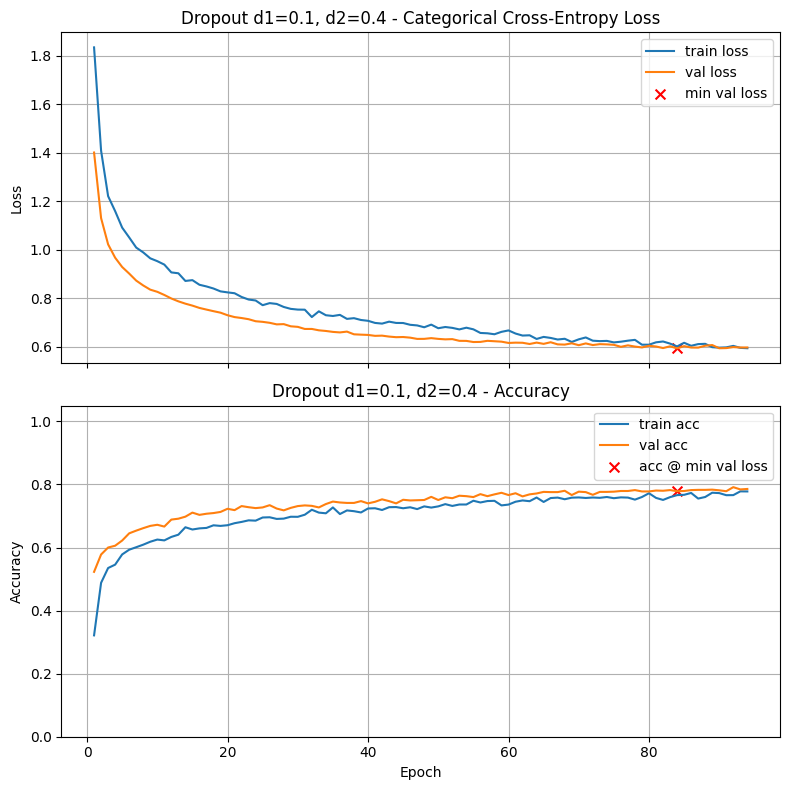

Final Training Loss:            0.5940
Final Training Accuracy:        0.7779
Final Validation Loss:          0.5972
Final Validation Accuracy:      0.7857
Minimum Validation Loss:        0.5934 (Epoch 84)
Validation Accuracy @ Min Loss: 0.7786

Test Loss: 0.6270
Test Accuracy: 0.7557

Validation-Test Gap (accuracy): 0.022857

Execution Time: 00:00:50

Dropout d1=0.1, d2=0.5



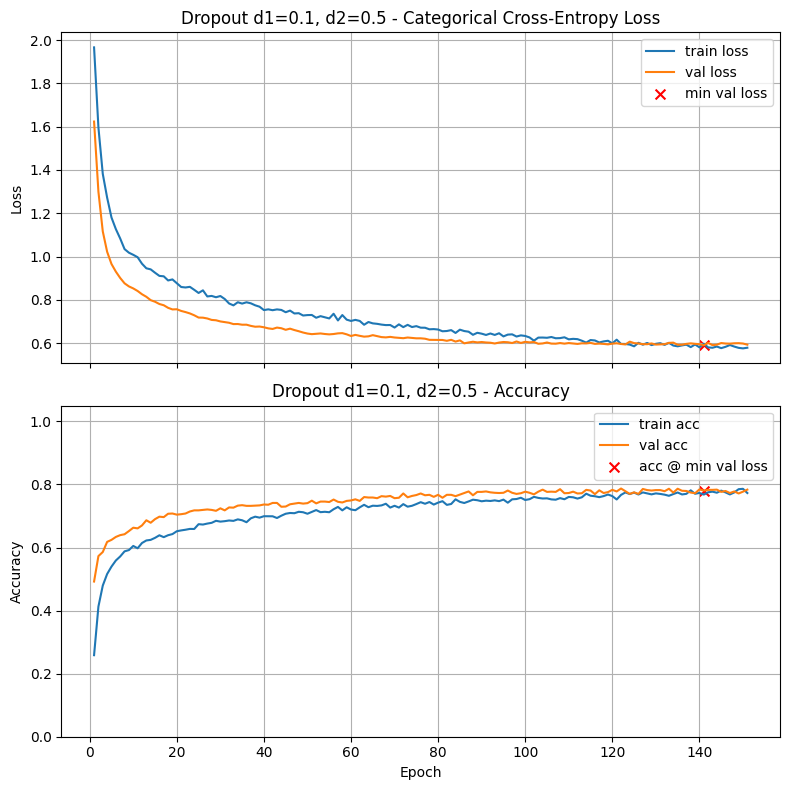

Final Training Loss:            0.5788
Final Training Accuracy:        0.7729
Final Validation Loss:          0.5928
Final Validation Accuracy:      0.7836
Minimum Validation Loss:        0.5902 (Epoch 141)
Validation Accuracy @ Min Loss: 0.7807

Test Loss: 0.6344
Test Accuracy: 0.7657

Validation-Test Gap (accuracy): 0.015000

Execution Time: 00:01:08

Dropout d1=0.2, d2=0.3



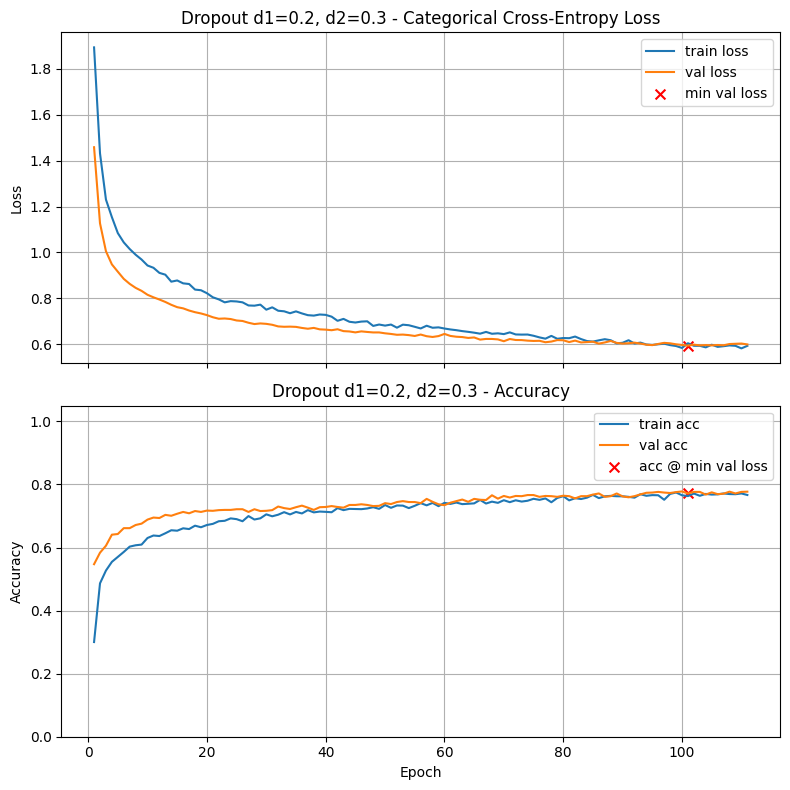

Final Training Loss:            0.5934
Final Training Accuracy:        0.7667
Final Validation Loss:          0.5996
Final Validation Accuracy:      0.7771
Minimum Validation Loss:        0.5944 (Epoch 101)
Validation Accuracy @ Min Loss: 0.7714

Test Loss: 0.6394
Test Accuracy: 0.7557

Validation-Test Gap (accuracy): 0.015714

Execution Time: 00:00:47

Dropout d1=0.2, d2=0.4



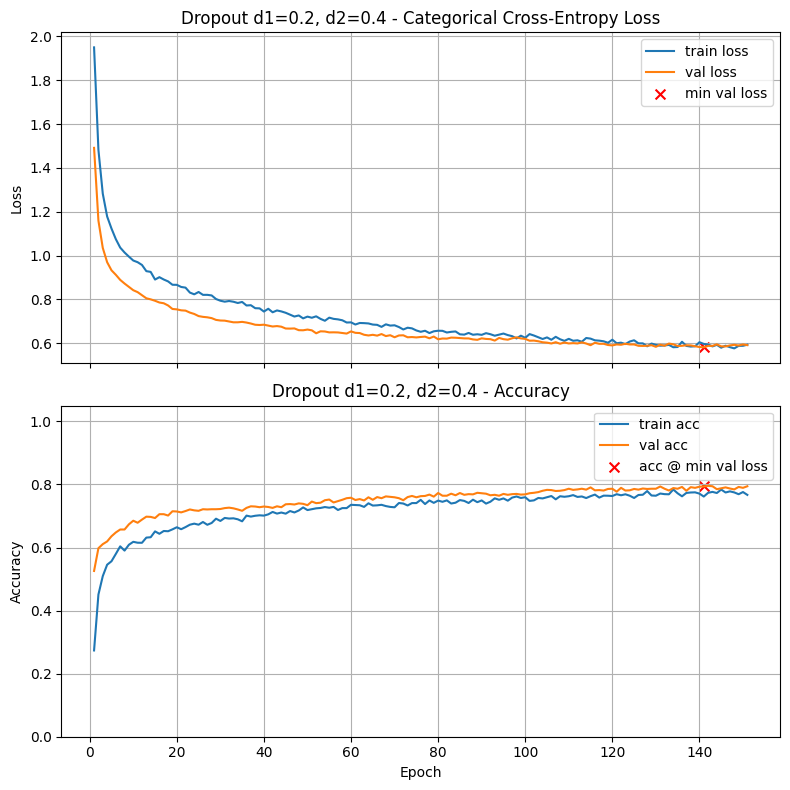

Final Training Loss:            0.5938
Final Training Accuracy:        0.7669
Final Validation Loss:          0.5918
Final Validation Accuracy:      0.7943
Minimum Validation Loss:        0.5821 (Epoch 141)
Validation Accuracy @ Min Loss: 0.7936

Test Loss: 0.6285
Test Accuracy: 0.7693

Validation-Test Gap (accuracy): 0.024286

Execution Time: 00:00:54

Dropout d1=0.2, d2=0.5



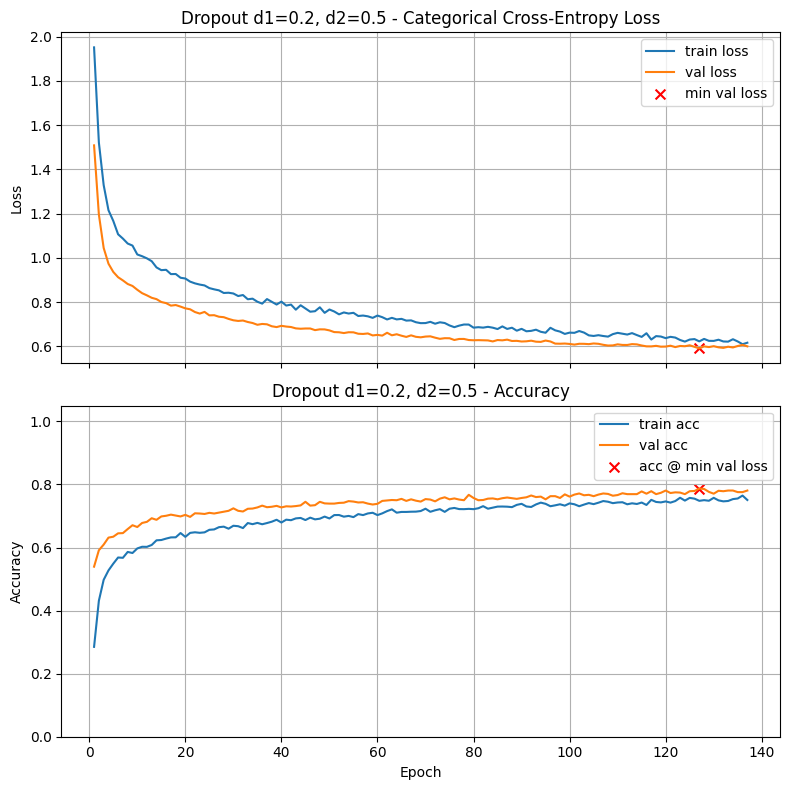

Final Training Loss:            0.6164
Final Training Accuracy:        0.7507
Final Validation Loss:          0.6001
Final Validation Accuracy:      0.7807
Minimum Validation Loss:        0.5908 (Epoch 127)
Validation Accuracy @ Min Loss: 0.7871

Test Loss: 0.6282
Test Accuracy: 0.7600

Validation-Test Gap (accuracy): 0.027143

Execution Time: 00:00:49


In [23]:
# Your code here. Add as many cells as you need. 
first_layer_dropouts = [0.0, 0.1, 0.2]
second_layer_dropouts = [0.3, 0.4, 0.5]

for d1 in first_layer_dropouts:
    for d2 in second_layer_dropouts:
        model = build_model(
            n_inputs=X_train.shape[1],
            layer_list=[
                (64, 'relu', 0.0,    d1),
                (32, 'relu', 0.001,  d2)
            ],
            n_classes=n_classes
        )

        title = f"Dropout d1={d1:.1f}, d2={d2:.1f}"
        train_and_test(
            model,
            title=title,
            lr_schedule=1e-3,   
            epochs=500,
            verbose=0
        )


In [25]:
print_results()


Dropout d1=0.2, d2=0.4                  	0.7936
LR = 1e-03                              	0.7921
Dropout d1=0.2, d2=0.5                  	0.7871
Dropout d1=0.1, d2=0.5                  	0.7807
Dropout d1=0.0, d2=0.4                  	0.7800
Baseline - ReLU                         	0.7793
Dropout d1=0.1, d2=0.4                  	0.7786
Dropout d1=0.1, d2=0.3                  	0.7743
Dropout d1=0.0, d2=0.3                  	0.7714
Dropout d1=0.2, d2=0.3                  	0.7714
Dropout d1=0.0, d2=0.5                  	0.7707
LR = 5e-04                              	0.7664
Baseline - Tanh                         	0.7629
LR = 1e-04                              	0.7557
Baseline - Sigmoid                      	0.7529
LR = 5e-05                              	0.7457
LR = 1e-05                              	0.6721


In [26]:
# Set a3a to the pair (dropout_rate_64,dropout_rate_32) of dropout rates for the two hidden layers which provided the best 
# validation accuracy at the epoch of minimum validation loss

a3a = (0.2,0.4)             # Replace (0.0,0.0) with your answer

In [27]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3a = {a3a}') 

a3a = (0.2, 0.4)


In [28]:
# Set a3b to the validation accuracy found by this best pair of dropout rates

a3b = 0.7936             # Replace 0.0 with your answer

In [29]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3b = {a3b:.4f}') 

a3b = 0.7936


### Problem Four: L2 Regularization

In this problem, you will explore how **L2 regularization** (also called *weight decay*) can help prevent overfitting in neural networks. There are no absolute rules, but some useful heuristics are:

* Start simple by using the **same λ in both hidden layers**, with values:

  ```
      1e-4, 1e-3, 1e-2
  ```

* If validation results suggest underfitting in the first layer or persistent overfitting in the later one, then try adjusting per layer, for example:

  * First hidden layer: λ = 1e-4
  * Second hidden layer: λ = 1e-3

**Steps to follow:**

* Build and train the **baseline model** using the **activation function from Problem One** and the **learning rate from Problem Two**, but **without dropout**.
* Investigate at least the four cases suggested (three with the same λ and one with different λ values). You may also consider additional combinations.
* Identify which configuration produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.



L2 λ1=1e-04, λ2=1e-04



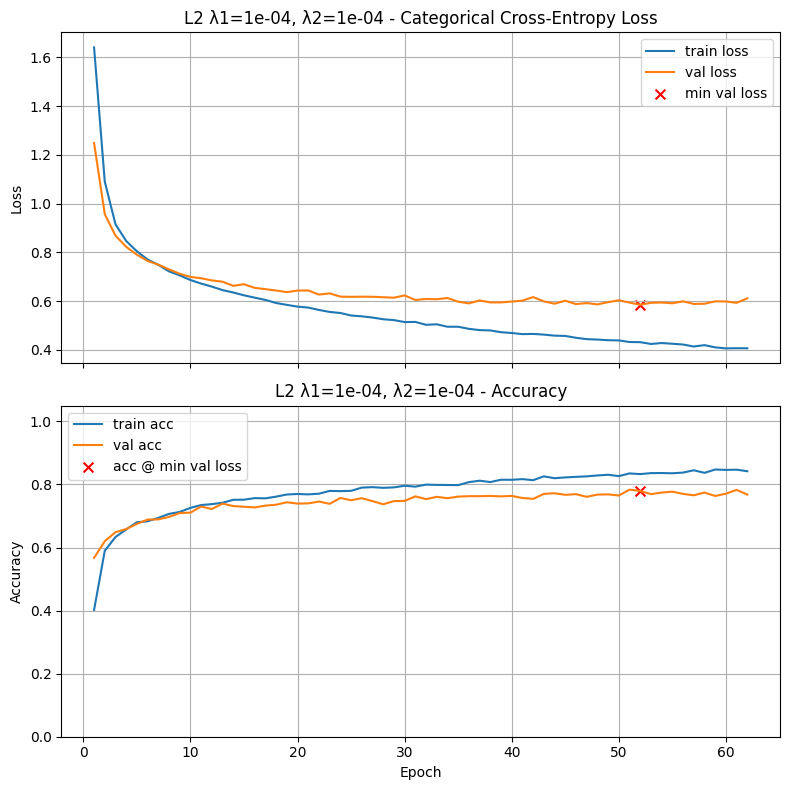

Final Training Loss:            0.4063
Final Training Accuracy:        0.8419
Final Validation Loss:          0.6112
Final Validation Accuracy:      0.7679
Minimum Validation Loss:        0.5846 (Epoch 52)
Validation Accuracy @ Min Loss: 0.7793

Test Loss: 0.6113
Test Accuracy: 0.7686

Validation-Test Gap (accuracy): 0.010714

Execution Time: 00:00:34

L2 λ1=1e-03, λ2=1e-03



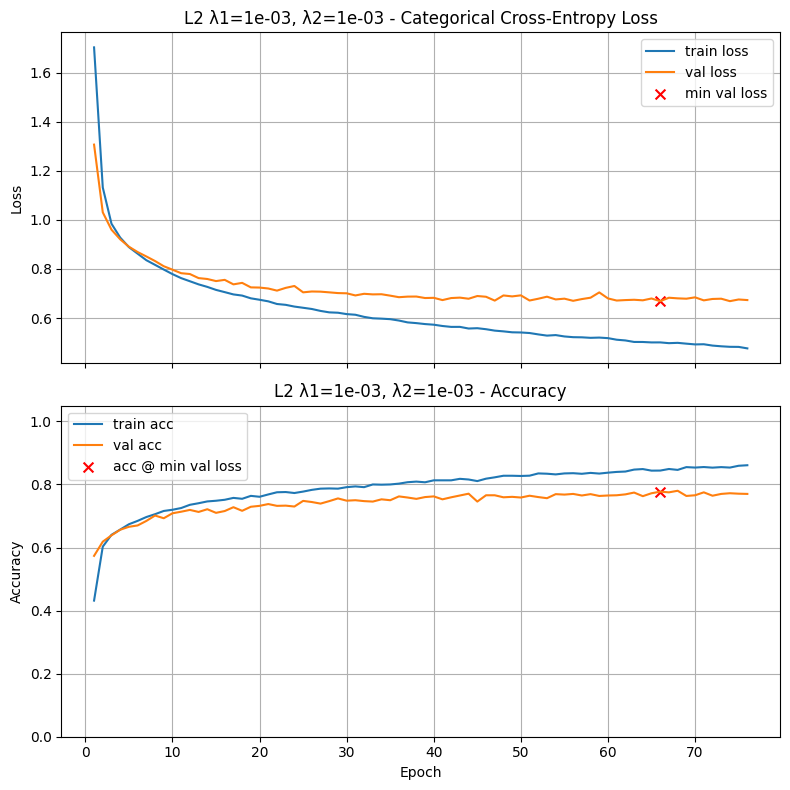

Final Training Loss:            0.4766
Final Training Accuracy:        0.8610
Final Validation Loss:          0.6734
Final Validation Accuracy:      0.7700
Minimum Validation Loss:        0.6689 (Epoch 66)
Validation Accuracy @ Min Loss: 0.7771

Test Loss: 0.6866
Test Accuracy: 0.7650

Validation-Test Gap (accuracy): 0.012143

Execution Time: 00:00:37

L2 λ1=1e-02, λ2=1e-02



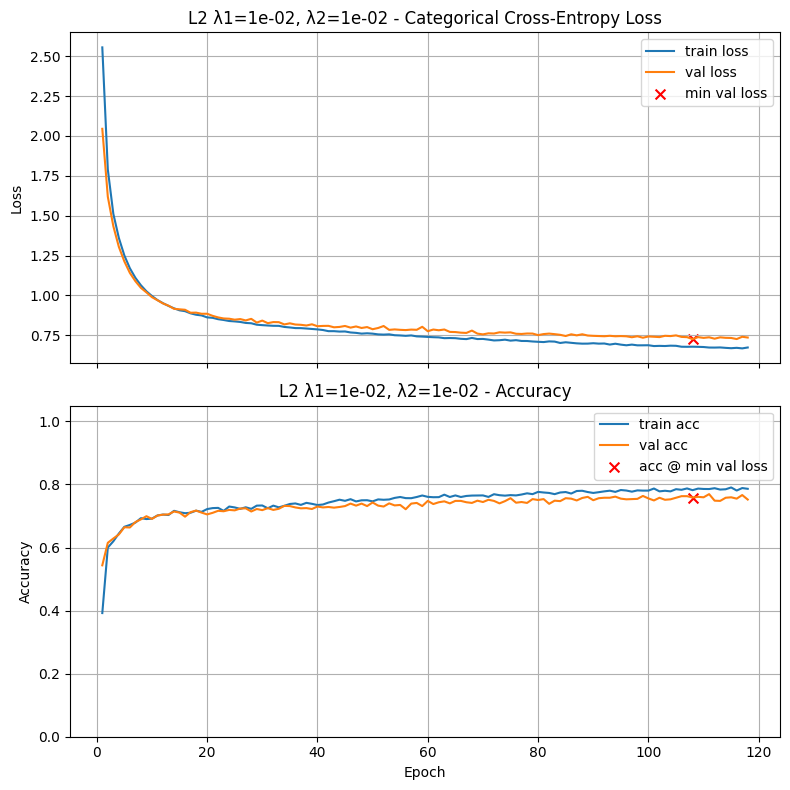

Final Training Loss:            0.6727
Final Training Accuracy:        0.7862
Final Validation Loss:          0.7353
Final Validation Accuracy:      0.7521
Minimum Validation Loss:        0.7252 (Epoch 108)
Validation Accuracy @ Min Loss: 0.7586

Test Loss: 0.7421
Test Accuracy: 0.7536

Validation-Test Gap (accuracy): 0.005000

Execution Time: 00:00:49

L2 λ1=1e-04, λ2=1e-03



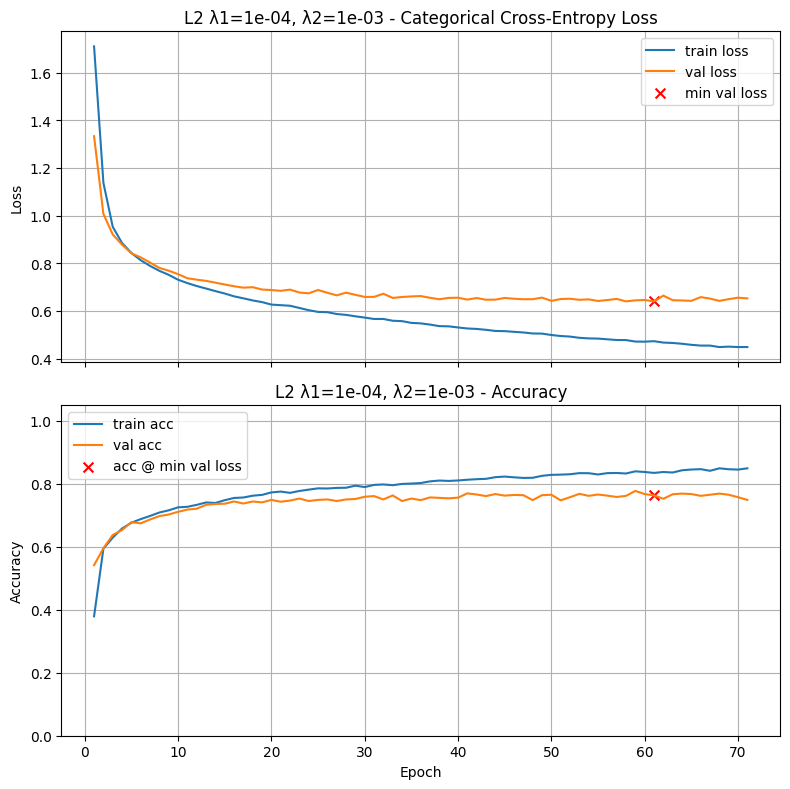

Final Training Loss:            0.4484
Final Training Accuracy:        0.8488
Final Validation Loss:          0.6524
Final Validation Accuracy:      0.7486
Minimum Validation Loss:        0.6398 (Epoch 61)
Validation Accuracy @ Min Loss: 0.7629

Test Loss: 0.6556
Test Accuracy: 0.7629

Validation-Test Gap (accuracy): 0.000000

Execution Time: 00:00:28


In [30]:
# Your code here. Add as many cells as you need. 
configs = [
    (1e-4, 1e-4),
    (1e-3, 1e-3),
    (1e-2, 1e-2),
    (1e-4, 1e-3),  
]

for l2_1, l2_2 in configs:
    model = build_model(
        n_inputs=X_train.shape[1],
        layer_list=[
            (64, 'relu', l2_1, 0.0),  
            (32, 'relu', l2_2, 0.0)
        ],
        n_classes=n_classes
    )

    title = f"L2 λ1={l2_1:.0e}, λ2={l2_2:.0e}"
    train_and_test(
        model,
        title=title,
        lr_schedule=1e-3,
        epochs=500,
        verbose=0
    )


In [31]:
print_results()

Dropout d1=0.2, d2=0.4                  	0.7936
LR = 1e-03                              	0.7921
Dropout d1=0.2, d2=0.5                  	0.7871
Dropout d1=0.1, d2=0.5                  	0.7807
Dropout d1=0.0, d2=0.4                  	0.7800
Baseline - ReLU                         	0.7793
L2 λ1=1e-04, λ2=1e-04                   	0.7793
Dropout d1=0.1, d2=0.4                  	0.7786
L2 λ1=1e-03, λ2=1e-03                   	0.7771
Dropout d1=0.1, d2=0.3                  	0.7743
Dropout d1=0.0, d2=0.3                  	0.7714
Dropout d1=0.2, d2=0.3                  	0.7714
Dropout d1=0.0, d2=0.5                  	0.7707
LR = 5e-04                              	0.7664
Baseline - Tanh                         	0.7629
L2 λ1=1e-04, λ2=1e-03                   	0.7629
L2 λ1=1e-02, λ2=1e-02                   	0.7586
LR = 1e-04                              	0.7557
Baseline - Sigmoid                      	0.7529
LR = 5e-05                              	0.7457
LR = 1e-05                              

In [32]:
# Set a4a to the pair (L2_lambda_64,L2_lambda_32) of the L2 lambdas for the two hidden layers which provided the best 
# validation accuracy at the epoch of minimum validation loss

a4a = (1e-4,1e-4)             # Replace (0.0,0.0) with your answer

In [33]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4a = {a4a}') 

a4a = (0.0001, 0.0001)


In [34]:
# Set a4b to the validation accuracy found by this best pair of lambdas

a4b = 0.7793             # Replace 0.0 with your answer

In [35]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4b = {a4b:.4f}') 

a4b = 0.7793


### Problem Five: Combining Dropout with L2 Regularization

In this problem, you will explore how **dropout** and **L2 regularization** can work together to prevent overfitting. These two methods complement each other, but must be balanced carefully. A useful rule of thumb is:

* If dropout is **high**, use a **smaller λ**.
* If dropout is **low**, you can afford a **larger λ**.

**Steps to follow:**

* Build and train the **baseline model** using the **activation function from Problem One** and the **learning rate from Problem Two**.
* Investigate combinations of dropout and L2:

  * First, use the **dropout rate you identified in Problem Three** as a baseline.
  * Then, add L2 to both hidden layers with values:

    ```
        1e-4, 1e-3, 1e-2
    ```

    while keeping dropout fixed.
  * Finally, try **reducing dropout slightly** when L2 is added to see if performance improves.
  * [Optional] You may wish to investigate other combinations not covered here; for example, promising but not optimal choices of dropout rates may provide overall better performance when combines with L2 Regulari 
* Identify which combination produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.




Dropout d=(0.2,0.4) + L2=1e-04



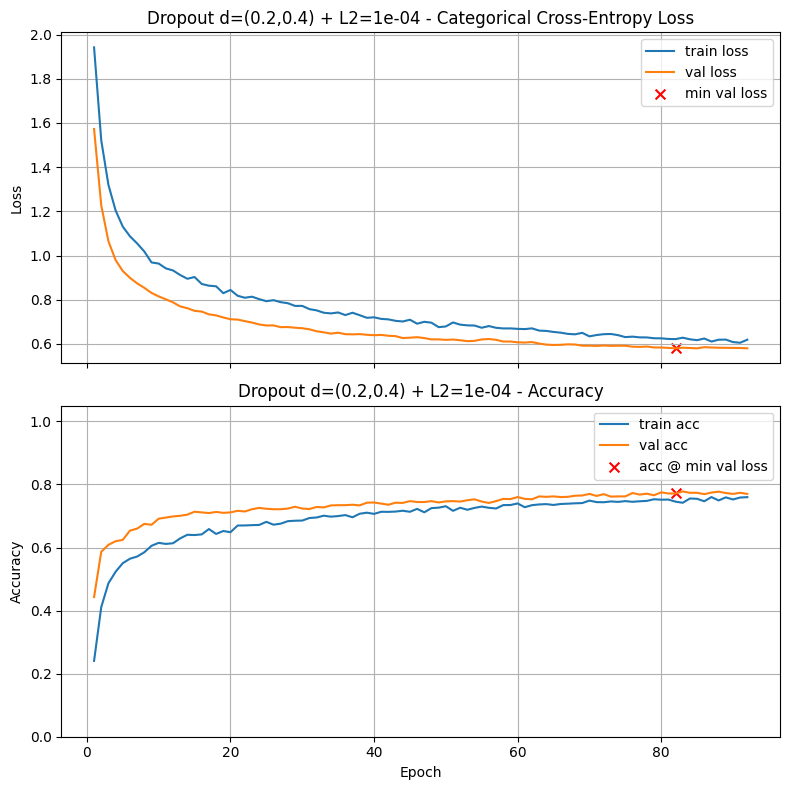

Final Training Loss:            0.6189
Final Training Accuracy:        0.7598
Final Validation Loss:          0.5799
Final Validation Accuracy:      0.7700
Minimum Validation Loss:        0.5795 (Epoch 82)
Validation Accuracy @ Min Loss: 0.7714

Test Loss: 0.6334
Test Accuracy: 0.7579

Validation-Test Gap (accuracy): 0.013571

Execution Time: 00:01:08

Dropout d=(0.2,0.4) + L2=1e-03



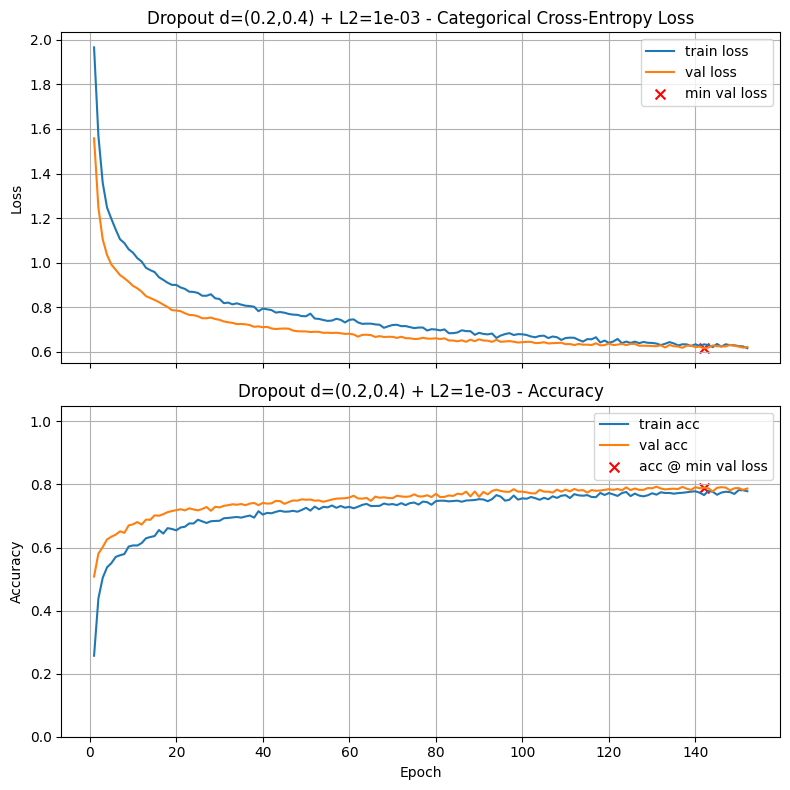

Final Training Loss:            0.6163
Final Training Accuracy:        0.7786
Final Validation Loss:          0.6216
Final Validation Accuracy:      0.7871
Minimum Validation Loss:        0.6152 (Epoch 142)
Validation Accuracy @ Min Loss: 0.7900

Test Loss: 0.6597
Test Accuracy: 0.7564

Validation-Test Gap (accuracy): 0.033571

Execution Time: 00:01:47

Dropout d=(0.2,0.4) + L2=1e-02



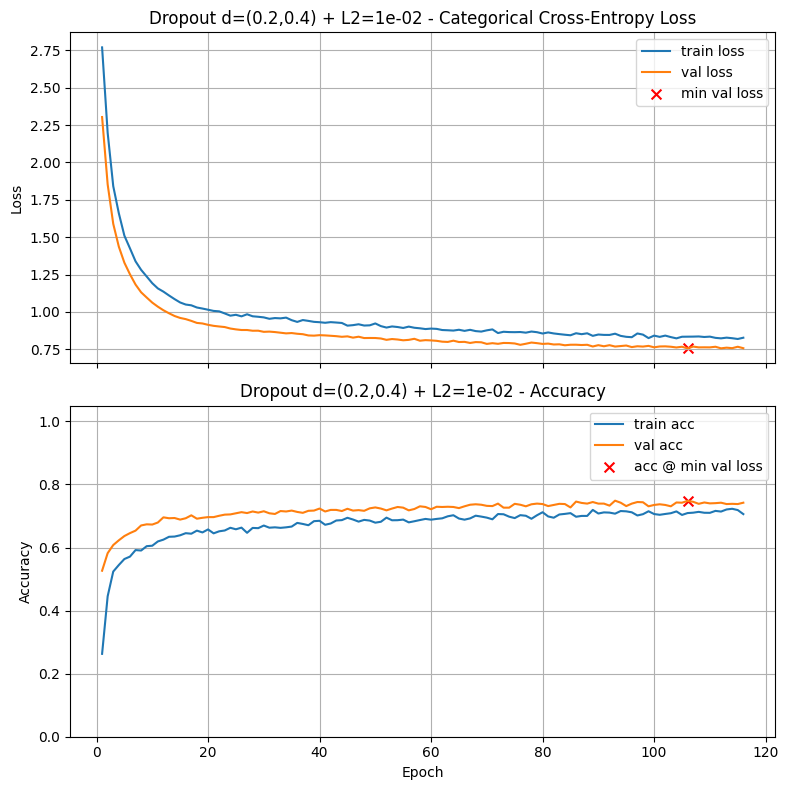

Final Training Loss:            0.8276
Final Training Accuracy:        0.7060
Final Validation Loss:          0.7574
Final Validation Accuracy:      0.7421
Minimum Validation Loss:        0.7562 (Epoch 106)
Validation Accuracy @ Min Loss: 0.7479

Test Loss: 0.7821
Test Accuracy: 0.7286

Validation-Test Gap (accuracy): 0.019286

Execution Time: 00:01:32


In [36]:
# Your code here. Add as many cells as you need.
fixed_dropout = (0.2, 0.4)
l2_values = [1e-4, 1e-3, 1e-2]

for l2_val in l2_values:
    model = build_model(
        n_inputs=X_train.shape[1],
        layer_list=[
            (64, 'relu', l2_val, fixed_dropout[0]),
            (32, 'relu', l2_val, fixed_dropout[1])
        ],
        n_classes=n_classes
    )

    title = f"Dropout d=(0.2,0.4) + L2={l2_val:.0e}"
    train_and_test(model, title=title, lr_schedule=1e-3, epochs=500, verbose=0)



Dropout d=(0.1,0.3) + L2=1e-03



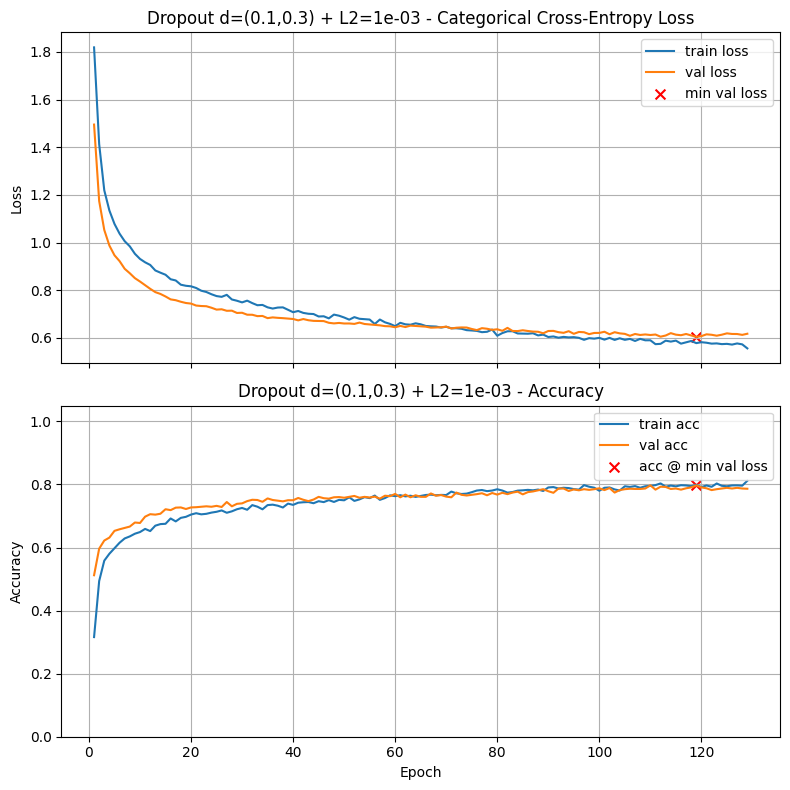

Final Training Loss:            0.5557
Final Training Accuracy:        0.8117
Final Validation Loss:          0.6171
Final Validation Accuracy:      0.7864
Minimum Validation Loss:        0.6040 (Epoch 119)
Validation Accuracy @ Min Loss: 0.7971

Test Loss: 0.6513
Test Accuracy: 0.7636

Validation-Test Gap (accuracy): 0.033571

Execution Time: 00:01:40

Dropout d=(0.2,0.3) + L2=1e-03



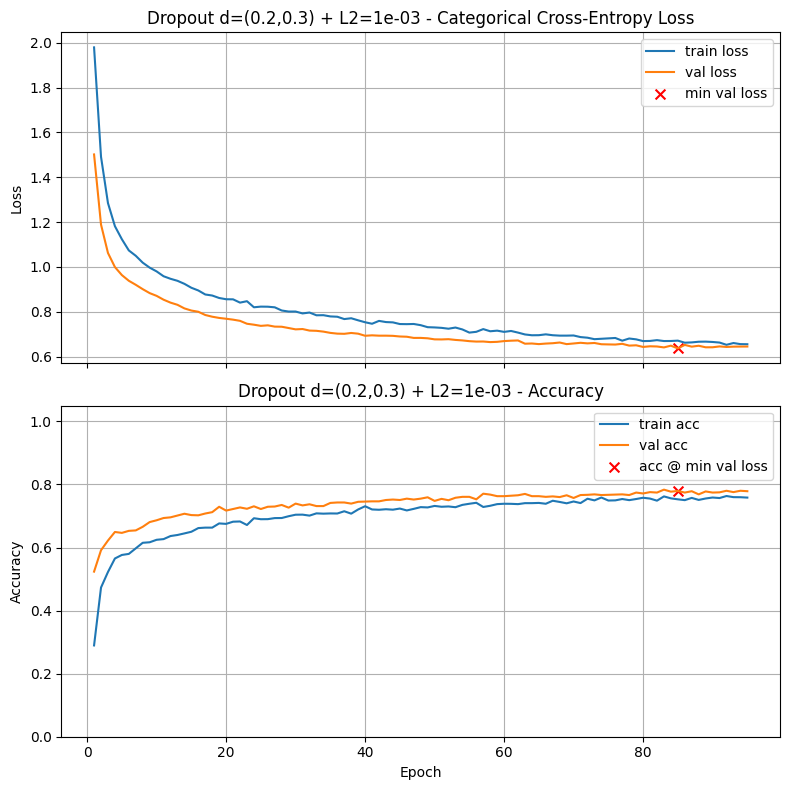

Final Training Loss:            0.6548
Final Training Accuracy:        0.7583
Final Validation Loss:          0.6446
Final Validation Accuracy:      0.7786
Minimum Validation Loss:        0.6363 (Epoch 85)
Validation Accuracy @ Min Loss: 0.7793

Test Loss: 0.6654
Test Accuracy: 0.7579

Validation-Test Gap (accuracy): 0.021429

Execution Time: 00:01:12

Dropout d=(0.1,0.4) + L2=1e-04



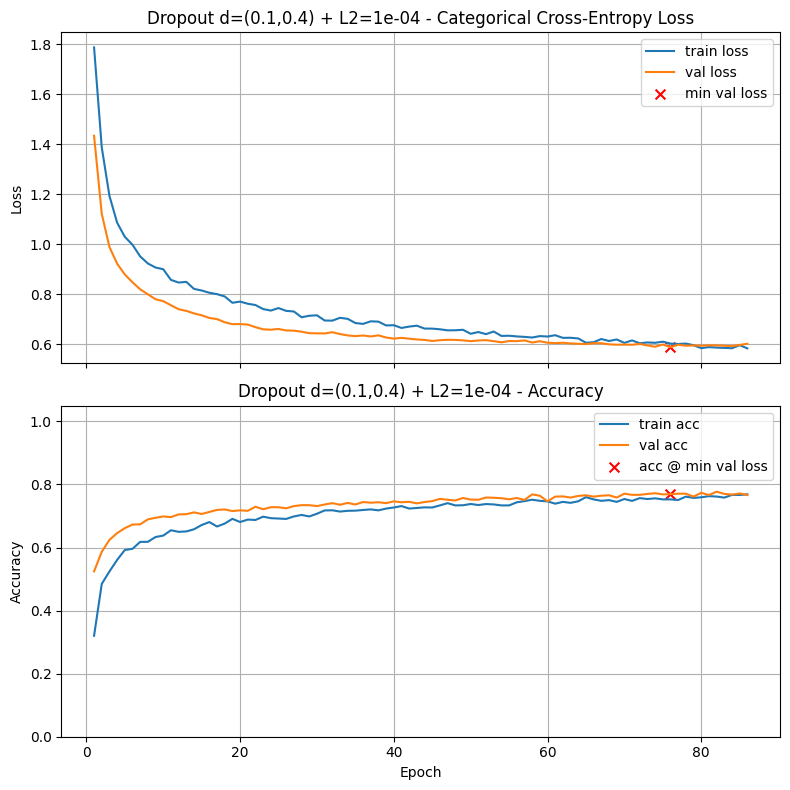

Final Training Loss:            0.5827
Final Training Accuracy:        0.7686
Final Validation Loss:          0.6012
Final Validation Accuracy:      0.7664
Minimum Validation Loss:        0.5869 (Epoch 76)
Validation Accuracy @ Min Loss: 0.7693

Test Loss: 0.6452
Test Accuracy: 0.7493

Validation-Test Gap (accuracy): 0.020000

Execution Time: 00:01:08


In [37]:
new_combos = [
    ((0.1, 0.3), 1e-3),
    ((0.2, 0.3), 1e-3),
    ((0.1, 0.4), 1e-4),
]

for (d1, d2), l2_val in new_combos:
    model = build_model(
        n_inputs=X_train.shape[1],
        layer_list=[
            (64, 'relu', l2_val, d1),
            (32, 'relu', l2_val, d2)
        ],
        n_classes=n_classes
    )

    title = f"Dropout d=({d1},{d2}) + L2={l2_val:.0e}"
    train_and_test(model, title=title, lr_schedule=1e-3, epochs=500, verbose=0)


In [38]:
print_results()

Dropout d=(0.1,0.3) + L2=1e-03          	0.7971
Dropout d1=0.2, d2=0.4                  	0.7936
LR = 1e-03                              	0.7921
Dropout d=(0.2,0.4) + L2=1e-03          	0.7900
Dropout d1=0.2, d2=0.5                  	0.7871
Dropout d1=0.1, d2=0.5                  	0.7807
Dropout d1=0.0, d2=0.4                  	0.7800
Baseline - ReLU                         	0.7793
L2 λ1=1e-04, λ2=1e-04                   	0.7793
Dropout d=(0.2,0.3) + L2=1e-03          	0.7793
Dropout d1=0.1, d2=0.4                  	0.7786
L2 λ1=1e-03, λ2=1e-03                   	0.7771
Dropout d1=0.1, d2=0.3                  	0.7743
Dropout d1=0.0, d2=0.3                  	0.7714
Dropout d1=0.2, d2=0.3                  	0.7714
Dropout d=(0.2,0.4) + L2=1e-04          	0.7714
Dropout d1=0.0, d2=0.5                  	0.7707
Dropout d=(0.1,0.4) + L2=1e-04          	0.7693
LR = 5e-04                              	0.7664
Baseline - Tanh                         	0.7629
L2 λ1=1e-04, λ2=1e-03                   

In [39]:
# Set a5 to the validation accuracy found by this best combination of dropout and L2 regularization

a5 = 0.7971             # Replace 0.0 with your answer

In [40]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a5 = {a5:.4f}') 

a5 = 0.7971


### Problem Six: Build and Train Your Best Model

In this final problem, you will design and train your **best-performing model** using the techniques explored in the previous problems. You may make your own choices for:

* **Model architecture** (number of layers, widths, etc.)
* **Learning rate**
* **Batch size** (a new hyperparameter not varied in earlier problems)
* **Dropout rates** in both layers
* **L2 λ values** in both layers
* **[Optional but strongly suggested]:** Learning rate scheduling, using either **Exponential Decay** or **Cosine Decay**.

  * For Exponential Decay, typical decay rates are **0.90–0.999**, with **0.95** often a good starting point.

**Steps to follow:**

* Build and train the model according to your design choices.
* Use early stopping as before to evaluate performance at the epoch of **minimum validation loss**.
* Answer the graded question.



Final Best Model (128→64→32, ReLU, Dropout+L2, LR Decay)



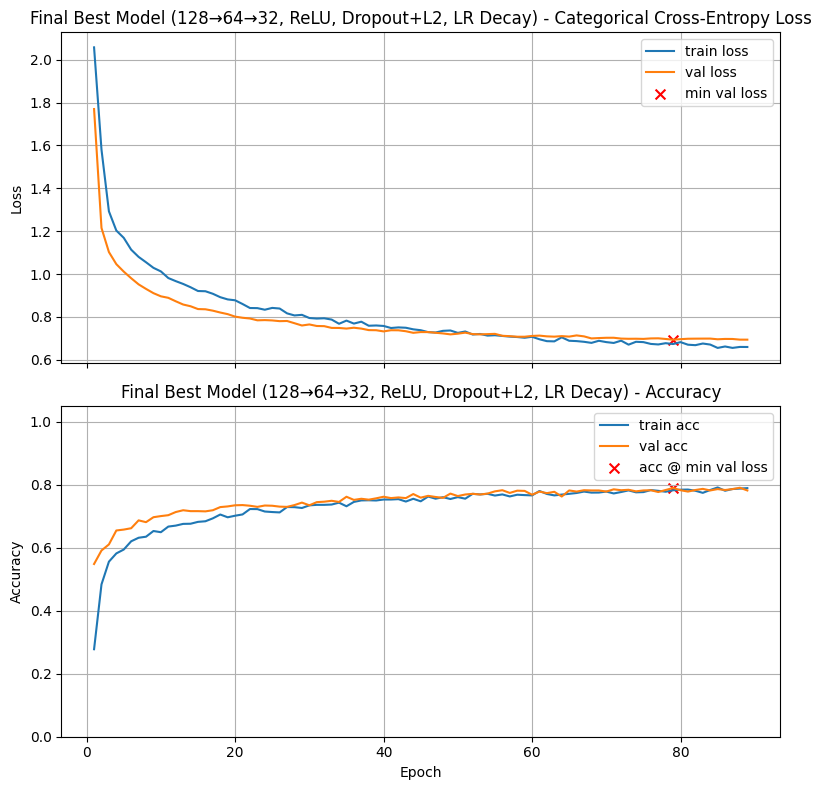

Final Training Loss:            0.6597
Final Training Accuracy:        0.7895
Final Validation Loss:          0.6939
Final Validation Accuracy:      0.7821
Minimum Validation Loss:        0.6938 (Epoch 79)
Validation Accuracy @ Min Loss: 0.7900

Test Loss: 0.7159
Test Accuracy: 0.7679

Validation-Test Gap (accuracy): 0.022143

Execution Time: 00:00:57


In [41]:
# Your code here

model_best = build_model(
    n_inputs=X_train.shape[1],
    layer_list=[
        (128, 'relu', 1e-3, 0.1),
        (64,  'relu', 1e-3, 0.1),
        (32,  'relu', 1e-3, 0.3)
    ],
    n_classes=n_classes
)

lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=100,
    decay_rate=0.95,
    staircase=True
)

train_and_test(
    model=model_best,
    lr_schedule=lr_schedule,
    batch_size=128,
    title="Final Best Model (128→64→32, ReLU, Dropout+L2, LR Decay)",
    epochs=500,
    verbose=0
)


In [42]:
print_results()

Dropout d=(0.1,0.3) + L2=1e-03          	0.7971
Dropout d1=0.2, d2=0.4                  	0.7936
LR = 1e-03                              	0.7921
Dropout d=(0.2,0.4) + L2=1e-03          	0.7900
Final Best Model (128→64→32, ReLU, Dropout+L2, LR Decay)	0.7900
Dropout d1=0.2, d2=0.5                  	0.7871
Dropout d1=0.1, d2=0.5                  	0.7807
Dropout d1=0.0, d2=0.4                  	0.7800
Baseline - ReLU                         	0.7793
L2 λ1=1e-04, λ2=1e-04                   	0.7793
Dropout d=(0.2,0.3) + L2=1e-03          	0.7793
Dropout d1=0.1, d2=0.4                  	0.7786
L2 λ1=1e-03, λ2=1e-03                   	0.7771
Dropout d1=0.1, d2=0.3                  	0.7743
Dropout d1=0.0, d2=0.3                  	0.7714
Dropout d1=0.2, d2=0.3                  	0.7714
Dropout d=(0.2,0.4) + L2=1e-04          	0.7714
Dropout d1=0.0, d2=0.5                  	0.7707
Dropout d=(0.1,0.4) + L2=1e-04          	0.7693
LR = 5e-04                              	0.7664
Baseline - Tanh         

In [43]:
# Set a6 to the validation accuracy found by this best model

a6 = 0.7971             # Replace 0.0 with your answer

In [44]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a6 = {a6:.4f}') 

a6 = 0.7971


### Optional: Print out your results of all experiments

In [45]:
print_results()

Dropout d=(0.1,0.3) + L2=1e-03          	0.7971
Dropout d1=0.2, d2=0.4                  	0.7936
LR = 1e-03                              	0.7921
Dropout d=(0.2,0.4) + L2=1e-03          	0.7900
Final Best Model (128→64→32, ReLU, Dropout+L2, LR Decay)	0.7900
Dropout d1=0.2, d2=0.5                  	0.7871
Dropout d1=0.1, d2=0.5                  	0.7807
Dropout d1=0.0, d2=0.4                  	0.7800
Baseline - ReLU                         	0.7793
L2 λ1=1e-04, λ2=1e-04                   	0.7793
Dropout d=(0.2,0.3) + L2=1e-03          	0.7793
Dropout d1=0.1, d2=0.4                  	0.7786
L2 λ1=1e-03, λ2=1e-03                   	0.7771
Dropout d1=0.1, d2=0.3                  	0.7743
Dropout d1=0.0, d2=0.3                  	0.7714
Dropout d1=0.2, d2=0.3                  	0.7714
Dropout d=(0.2,0.4) + L2=1e-04          	0.7714
Dropout d1=0.0, d2=0.5                  	0.7707
Dropout d=(0.1,0.4) + L2=1e-04          	0.7693
LR = 5e-04                              	0.7664
Baseline - Tanh         

## Reflection Questions (ungraded)

1. Activation Functions:

    - Why do you think one activation function worked better than the others for this task?
    
    - How might this choice differ for deeper or wider networks?

2. Learning Rate:

    - Would a much smaller learning rate (with many more epochs) likely produce better accuracy?
    
    - When is it worth training longer with a smaller step size, and when is it unnecessary?

3. Dropout vs. L2:

    - Which form of regularization — dropout or L2 — gave better results in your experiments?
    
    - Why might one method be more effective in this setting?

4. Combining Dropout and L2:

    - Why might the combination of dropout and L2 sometimes perform worse than using one method alone?
    
    - What does this tell you about the balance between bias and variance in regularization?

5. Best Model:

    - When you designed your best model, what trade-offs did you notice between model complexity, training stability, and generalization?
    
    - Did learning rate scheduling (if you tried it) improve results? Why might it help?